## Imports


In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math

# Keras imports
from keras.models import Sequential
from keras.layers import Dense , Dropout

# Here we import the LSTM cell which allows us to make LSTM cells
# Here is the documentation for the LSTM cell in Keras https://keras.io/layers/recurrent/#lstm
#from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import Flatten
import keras


/usr/local/lib/python3.5/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.


## Read dataset

In [77]:
dataframe = pd.read_csv('UNRATE.csv')

### Display the dataset (first five values)

In [78]:
dataframe.head()

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


In [79]:
dataframe1 = dataframe[['UNRATE']] 
dataframe1.head()


,UNRATE
0,3.4
1,3.8
2,4.0
3,3.9
4,3.5


## Plot of all the data ( US civilian unemployment rate in percentage)

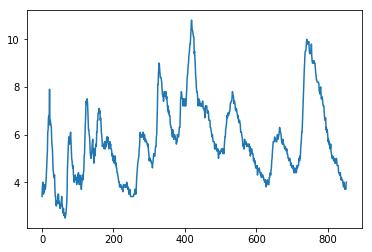

In [80]:
plt.plot(dataframe1[0:])
plt.show()

## WE Scale OUR DATA

Scale the data so that all the values are between 0 and 1. Here we make use of ScikitLearn's MinMaxScaler() function. There are alternatives. Here is a link to various pre-processing steps that you can use: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataframe1 = scaler.fit_transform(dataframe1)

## We create labels for our datasets.
As it stands, the dataset does not have labels (targets) - i.e. the things you want to predict. The dataset just has values of the US unemployment rate for each month across multiple years. We need to create our predictions manually by shifting the data. 

<b> Note: </b>

The function <i>create_dataset</i> shifts the data in such a way that we can create features and targets.

In [82]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-5):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back+5, 0])
    return np.array(dataX), np.array(dataY)

In [83]:
dataX,dataY=create_dataset(dataframe1,look_back=1)

## We split our dataset using 70 percent for training and 30 percent for testing.
It's not a good idea to train your model on just your training data because then you cannot check it's performance on data that it has never seen before. A good idea is to split your data into at least a training and testing set.

"Training Dataset: The sample of data used to fit the model."

"Test Dataset: The sample of data used to provide an <b>unbiased evaluation</b> of a final model fit on the training dataset."

You can read more about this here: https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7

In [ ]:
# Define the amount of data that will be used for training. This is a slightly different approach to using Scikit
# learn's built in function train_test_split. Here we are the splitting manually. 

In [84]:
train_size = int(len(dataframe1) * 0.7)
test_size = len(dataframe1) - train_size
train, test = dataframe1[0:train_size,:], dataframe1[train_size:len(dataframe1),:]

In [85]:
look_back = 12 # window size of 12.

# Split the data into training features and training targets
trainX, trainY = create_dataset(train, look_back)

# Split the data into testing features and testing targets
testX, testY = create_dataset(test, look_back)

### Print out the shape of the data

Always a good idea to print the shapes to make sure that everything worked well.

In [86]:
print('Train X shape ',trainX.shape)
print('Train Y shape',trainY.shape)
print('Test X shape ',testX.shape)
print('Test Y shape ',testY.shape)

Train X shape  (580, 12)
Train Y shape (580,)
Test X shape  (239, 12)
Test Y shape  (239,)


## We now build our model

In [87]:
model=Sequential()
model.add(Dense(50,activation='relu',input_dim=12))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mae', 'mse'] )
model.summary()          



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 50)                650       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________


### Start training the model

We need to specify a few things:

<li> training features
<li> training targets
<li> number of epochs

<li> batch size

We also mention the verbose which denotes how much we are outputing to the screen during the training process

In [88]:
history=model.fit(trainX, trainY, epochs=1000, batch_size=1,validation_split=0.2, verbose=0, shuffle=False)

In [89]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,0.020192,0.099684,0.020192,0.012923,0.078834,0.012923,0
1,0.012911,0.084104,0.012911,0.008964,0.075382,0.008964,1
2,0.010573,0.078954,0.010573,0.008495,0.075298,0.008495,2
3,0.010416,0.079130,0.010416,0.008258,0.075676,0.008258,3
4,0.010225,0.078845,0.010225,0.007906,0.074434,0.007906,4


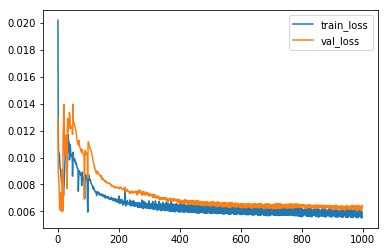

In [90]:
hist.plot
plt.plot(hist['loss'],label='train_loss')
plt.plot(hist['val_loss'],label='val_loss')
plt.legend()
plt.show()

## Predict on the test data and prepare the data for plotting

In [91]:
# generate predictions for training
trainPredict = model.predict(trainX, batch_size=1)
testPredict = model.predict(testX, batch_size=1)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataframe1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataframe1)-9, :] = testPredict

## Plot the predictions and the actual data in scaled coordinate

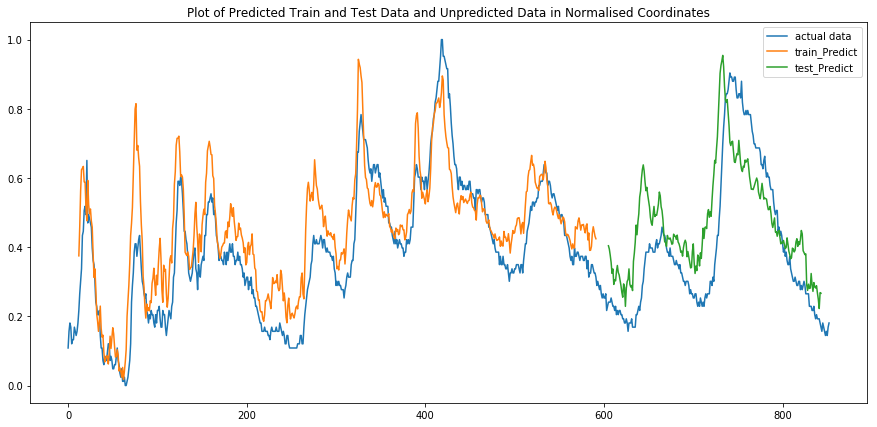

In [92]:
plt.figure(figsize=(15,7))
plt.plot(dataframe1,label="actual data")
plt.plot(trainPredictPlot, label="train_Predict")
plt.plot(testPredictPlot,label="test_Predict")
plt.title('Plot of Predicted Train and Test Data and Unpredicted Data in Normalised Coordinates')
plt.legend()
plt.show()

### Invert predictions and find rms errors in original coordinates

In [93]:
from sklearn.metrics import mean_squared_error
trainPredict_inv = scaler.inverse_transform(trainPredict)
trainY_inv = scaler.inverse_transform([trainY])
testPredict_inv = scaler.inverse_transform(testPredict)
testY_inv = scaler.inverse_transform([testY])
data=dataframe[['UNRATE']]
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inv[0], trainPredict_inv[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_inv[0], testPredict_inv[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.89 RMSE
Test Score: 0.91 RMSE


In [94]:
(mean_squared_error(testY_inv[0], testPredict_inv[:,0])) #finding the mean square error (MSE)

0.8342299293463546

In [1]:
from sklearn.metrics import mean_absolute_error


# Now we plot the predictions derived using the train and test data
# in the original coordinate

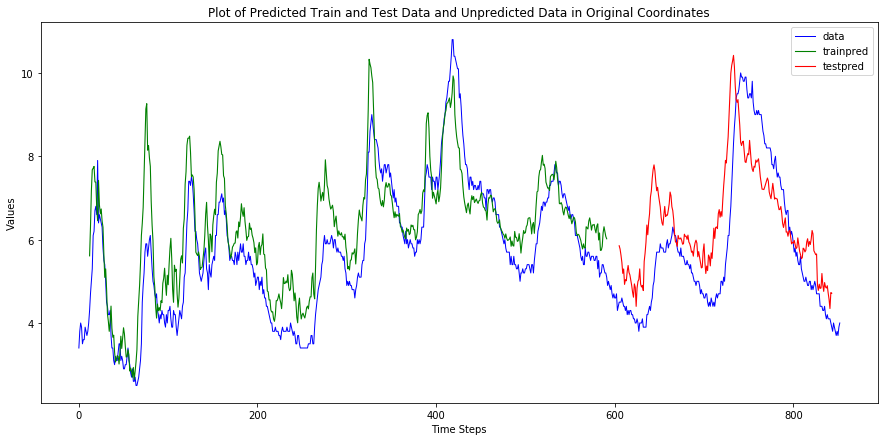

In [96]:
trainPredictPlot = np.empty_like(dataframe1)
trainPredictPlot[:, :] = np.nan    # Note that points with nan value are not plotted by matplotlib
trainPredictPlot[look_back:len(trainPredict_inv)+look_back, :] = trainPredict_inv
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict_inv)+(look_back*2)+1:len(data)-9, :] = testPredict_inv

# plot baseline and predictions
plt.figure(figsize=(15,7))
linewidth=1
dstep=10
plt.plot(data.values,'b',label='data',linewidth=linewidth)
plt.plot(trainPredictPlot,'g',label='trainpred',linewidth=linewidth+0.1)
plt.plot(testPredictPlot,'r',label='testpred',linewidth=linewidth+0.1)
plt.title('Plot of Predicted Train and Test Data and Unpredicted Data in Original Coordinates')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

## We plot only the test predict against the actual in original coordinate (Predictions using the test set against
## the actual value)

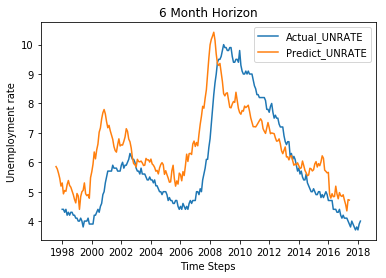

In [98]:
plt.plot([i for i in range(610,853)],data.values[610:,],
         label="Actual_UNRATE")
plt.plot(testPredictPlot,label="Predict_UNRATE")
plt.legend()
plt.title('6 Month Horizon')
plt.xlabel('Time Steps')
plt.ylabel('Unemployment rate')
xpos=[i for i in range(610,853,24)]
plt.xticks(xpos,[1998+(i*2) for i in range(len(xpos))])
plt.savefig("6 Month Horizon_MLP(MLPFH6TAKEOKAY).eps", format='eps', dpi=1000)
plt.show()


# we define a function to be used for calculating the MAPE

In [99]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Calculation of the Mean Absolute Percentage Error (MAPE) for the test Data

In [100]:
mean_absolute_percentage_error(testY_inv[0],testPredict_inv[:,0])

15.707106619528725

## Calculation of the Mean Absolute  Error for the test Data

In [101]:
mean_absolute_error(testY_inv[0],testPredict_inv[:,0])

0.8249041940377845

## Calculation of the Root Mean Square Error Error for the test Data

In [102]:
testScore = math.sqrt(mean_squared_error(testY_inv[0], testPredict_inv[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.91 RMSE
